# Working with time series, frequency series, and unit conversion

In this notebook, we show some of the most useful features of the [timeseries](../series.rst) module. To do so, we will analyze a fake gravitational-wave signal. We will also show the [frequencyseries](../series.rst) module and the [unitconv](../unitconv.rst) modules.

First, let's generate this signal. 

(This notebook is meant to be converted in Sphinx documentation and not used directly.)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from kuibit import timeseries as ts
from kuibit import series
from kuibit import unitconv as uc
from kuibit.gw_utils import luminosity_distance_to_redshift

%matplotlib inline

In [2]:
t = np.linspace(0, 20, 5000)
y = np.sin(t)

# Generate a TimeSeries by providing the times and the values of the series
gw = ts.TimeSeries(t, y)

To access the times and the values, use ``gw.t`` and ``gw.y``. You can also iterate over the series with a for loop yielding the elements `(t, y)` at each iteration of the loop. For example.

In [3]:
for tt, yy in gw:
    print(tt, yy)

0.0 0.0
0.004000800160032006 0.004000789486971321
0.008001600320064013 0.008001514935783532
0.012002400480096018 0.012002112309302542
0.016003200640128026 0.016002517572444287
0.020004000800160033 0.020002666693199687
0.024004800960192037 0.024002495643659576
0.028005601120224044 0.028001940401039562
0.03200640128025605 0.03200093694870479
0.03600720144028806 0.03599942127719461
0.040008001600320066 0.03999732938524717
0.04400880176035207 0.0439945972808238
0.048009601920384073 0.04799116098213332
0.05201040208041608 0.05198695651865616
0.05601120224044809 0.055981919932168285
0.060012002400480095 0.059975987277764924
0.0640128025605121 0.06396909462488413
0.0680136027205441 0.06796117805833003
0.07201440288057612 0.07195217367929596
0.07601520304060812 0.07594201760638712
0.08001600320064013 0.07993064597664322
0.08401680336067213 0.08391799494656059
0.08801760352070415 0.08790400069311417
0.09201840368073615 0.09188859941477902
0.09601920384076815 0.09587172733255157
0.10002000400080

-0.9971541247066926
4.640928185637128 -0.9974477637981256
4.64492898579716 -0.9977254373610525
4.648929785957192 -0.9979871409509243
4.652930586117224 -0.998232870378814
4.656931386277256 -0.9984626217114829
4.660932186437288 -0.9986763912714437
4.66493298659732 -0.9988741756370193
4.668933786757352 -0.9990559716423981
4.672934586917384 -0.9992217763776838
4.676935387077416 -0.999371587188943
4.680936187237448 -0.9995054016782466
4.68493698739748 -0.9996232177037092
4.688937787557512 -0.9997250333795223
4.692938587717544 -0.9998108470759858
4.696939387877576 -0.9998806574195329
4.700940188037608 -0.9999344632927526
4.70494098819764 -0.9999722638344076
4.708941788357672 -0.9999940584394481
4.712942588517704 -0.9999998467590214
4.716943388677736 -0.9999896287004775
4.720944188837768 -0.9999634044273703
4.7249449889978 -0.9999211743594558
4.728945789157832 -0.9998629391726843
4.732946589317864 -0.9997886997991905
4.736947389477896 -0.9996984574272779
4.740948189637928 -0.9995922135014005


0.18977324687666533
9.237847569513903 0.18584364116247054
9.241848369673935 0.18191106076422878
9.245849169833967 0.1779755686283185
9.249849969993999 0.17403722774772462
9.253850770154031 0.17009610116103
9.257851570314063 0.1661522519514067
9.261852370474095 0.1622057432456061
9.265853170634127 0.15825663821294847
9.26985397079416 0.15430500006431183
9.273854770954191 0.1503508920511203
9.277855571114223 0.14639437746433154
9.281856371274255 0.14243551963342377
9.285857171434287 0.13847438192538203
9.28985797159432 0.13451102774368398
9.293858771754351 0.130545520527285
9.297859571914383 0.12657792374960272
9.301860372074415 0.12260830091750115
9.305861172234447 0.11863671557027403
9.30986197239448 0.1146632312786279
9.313862772554511 0.11068791164366452
9.317863572714543 0.10671082029586287
9.321864372874575 0.10273202089406061
9.325865173034607 0.09875157712443519
9.32986597319464 0.09476955269948442
9.333866773354671 0.09078601135700667
9.337867573514703 0.0868010168590807
9.34186

13.690738147629526 0.9019947088558932
13.694738947789558 0.9037148192183275
13.69873974794959 0.9054204643774386
13.702740548109622 0.9071116170320209
13.706741348269654 0.9087882501128414
13.710742148429686 0.9104503367830729
13.714742948589718 0.9120978504387237
13.71874374874975 0.9137307647090631
13.722744548909782 0.9153490534570441
13.726745349069814 0.9169526907797209
13.730746149229846 0.9185416510086643
13.734746949389878 0.9201159087103721
13.73874774954991 0.9216754386866766
13.742748549709942 0.9232202159751473
13.746749349869974 0.9247502158494909
13.750750150030006 0.9262654138199475
13.754750950190038 0.9277657856336815
13.75875175035007 0.9292513072751708
13.762752550510102 0.9307219549665905
13.766753350670134 0.932177705168194
13.770754150830166 0.9336185345786897
13.774754950990198 0.9350444201356135
13.77875575115023 0.9364553390156988
13.782756551310262 0.9378512686352408
13.786757351470294 0.9392321866504588
13.790758151630326 0.9405980709578537
13.794758951790358

-0.8382057586952667
17.859571914382876 -0.8360172033821966
17.863572714542908 -0.8338152664596061
17.86757351470294 -0.8315999831725356
17.871574314862972 -0.8293713889796522
17.875575115023004 -0.8271295195526829
17.879575915183036 -0.8248744107758428
17.883576715343068 -0.8226060987452612
17.8875775155031 -0.8203246197684039
17.891578315663132 -0.8180300103634915
17.895579115823164 -0.8157223072589155
17.899579915983196 -0.81340154739265
17.903580716143228 -0.8110677679116606
17.90758151630326 -0.8087210061713098
17.911582316463292 -0.8063612997347591
17.915583116623324 -0.803988686372368
17.919583916783356 -0.8016032040610886
17.923584716943388 -0.7992048909838589
17.92758551710342 -0.7967937855289906
17.931586317263452 -0.7943699262895552
17.935587117423484 -0.7919333520627662
17.939587917583516 -0.7894841018493578
17.94358871774355 -0.7870222148529612
17.94758951790358 -0.7845477304794766
17.951590318063612 -0.7820606883364425
17.955591118223644 -0.7795611282324019
17.959591918383

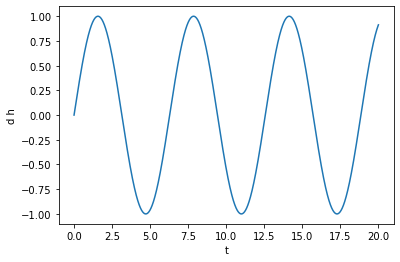

In [4]:
def plot(ser, lab1="d h", lab2="t", *args, **kwargs):
    """Plot Series ser with labels"""
    plt.ylabel(lab1)
    plt.xlabel(lab2)
    plt.plot(ser, *args, **kwargs)
    
plot(gw)

Let's make this more interesting: we square the signal and add Gaussian noise. [TimeSeries](../timeseries_ref.html#kuibit.timeseries.TimeSeries) support directly using all the basic mathematical operations in Python and NumPy, so we can easily square the signal and add another TimeSeries to it.

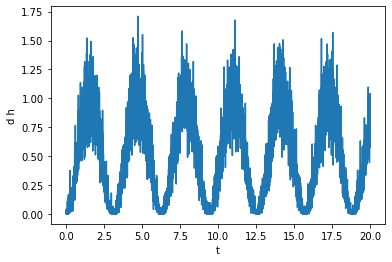

In [5]:
noise = np.random.normal(0, 0.1, len(gw))  # Here we used len() on the TimeSeries
noise_ts = ts.TimeSeries(t, noise)

gw += noise_ts
gw **= 2

plot(gw)

To analyze this signal, first we will smooth it. To do that, we will use the [savgol_smooth_time](../timeseries_ref.html#kuibit.timeseries.TimeSeries.savgol_smooth_time) method, which is a generalized "running average" filter. This method requires length of time over which we want to smooth the data.

In [TimeSeries](../timeseries_ref.html#kuibit.timeseries.TimeSeries) there are always two different methods to do the same task, one with imperative verb (e.g., smooth), and the other with the past tense (e.g., smoothed). The first modifies the data, the second returns a new `TimeSeries` with the operation applied. Here, we will find what smoothing length to use by trial and error, so we will use the second method. 

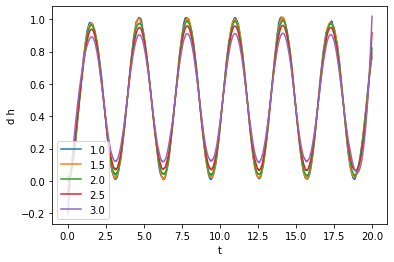

In [6]:
tsmooth = np.linspace(1, 3, 5)

for tsm in tsmooth:
    smoothed = gw.savgol_smoothed_time(tsm)
    plot(smoothed, label=tsm)
plt.legend()

From visual inspection it looks like that ``tsmooth = 1.5`` will work yield a clean series faithful to the original one.

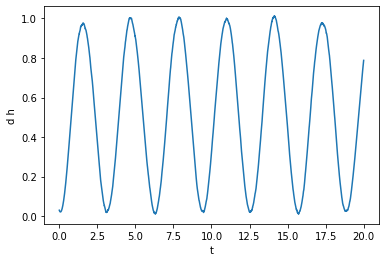

In [7]:
gw.savgol_smooth_time(1.5)
plot(gw)

Next, for fun, we can compute integrals and derivatives. For instance, we can compute what is the integral from 5 to 10.

The integral from 5 to 10 is 2.2091


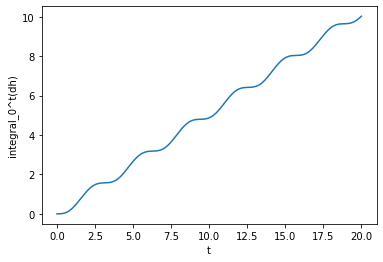

In [8]:
gw_int = gw.integrated()
a = 5
b = 10
print(f"The integral from {a} to {b} is {gw_int(b) - gw_int(a):.4f}")
plot(gw_int, lab1="integral_0^t(dh)")

Here, we showed a very powerful feature of `TimeSeries`: you can call them on a specific time (as we did we ``gw_int(b)``). This is done using splines to interpolate to the points that are not available. Splines can also be used to take derivatives. Alternatively, one can simply take the finite (central) difference. Let's see what's the derivative of ``gw`` using splines and finite difference.

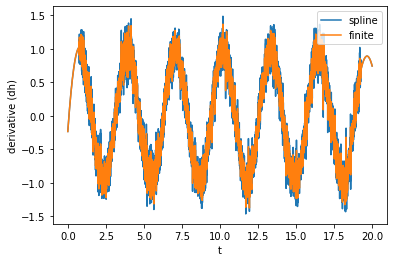

In [9]:
gw_spline_der = gw.spline_differentiated()
gw_numer_der = gw.differentiated()

plot(gw_spline_der, label='spline')
plot(gw_numer_der, lab1="derivative (dh)", label='finite')
plt.legend()

Clearly, derivatives will be noisier than the actual data, so often it is convenient to smooth them out as shown before.

TimeSeries support complex signals. Now, we will create one using `gw` itself. We will copy `gw`, time-shift it, find the common time interval with the original `gw`, and use that as a the imaginary part.

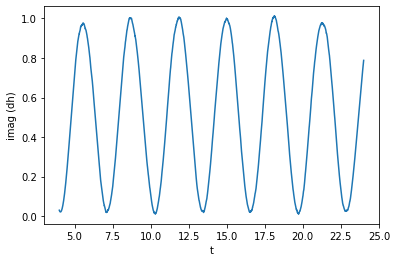

In [10]:
gw_imag = gw.copy()  # It is important to deep copy the object
gw_imag.time_shift(4)

plot(gw_imag, lab1 ="imag (dh)")

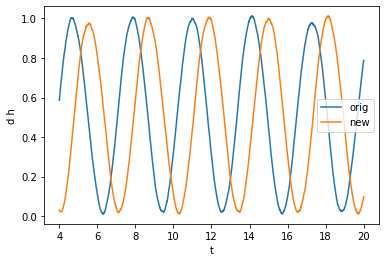

In [11]:
gw, gw_imag = series.sample_common([gw, gw_imag], resample=True)  # Resampling to common times

plot(gw, label="orig")
plot(gw_imag, label="new")
plt.legend()

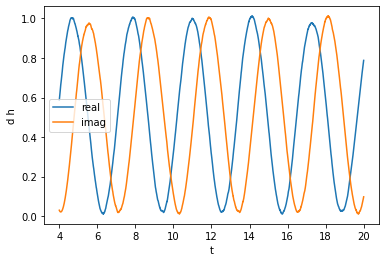

In [12]:
gw_complex = ts.TimeSeries(gw.t, gw.y + 1j * gw_imag.y)

plot(gw_complex.real(), label="real")
plot(gw_complex.imag(), label="imag")
plt.legend()

We can also compute the phase and absolute value. In particular, we will compute the unfolded phase (no wrapping over $2\pi$)

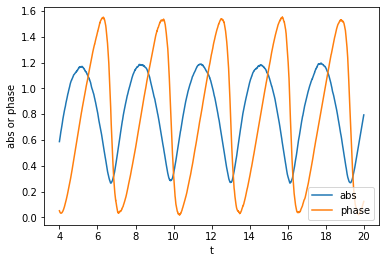

In [13]:
plot(gw_complex.abs(), label='abs')
plot(gw_complex.unfolded_phase(), lab1="abs or phase", label='phase')
plt.legend()

Here, the unfolded phase looks a little bit unusual. This is because we made up the signal.

We can also compute the frequency of the phase, which we can directly smooth.

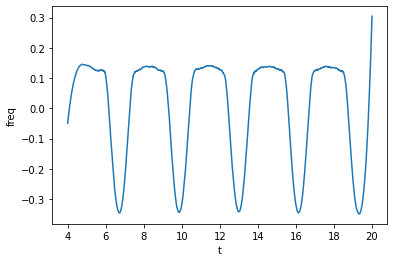

In [14]:
plot(gw_complex.phase_frequency(tsmooth=1.5), lab1="freq")

Next, we will take a Fourier transform. Before, let's pretend that the signal was in geometrized units (as in simulations), and let's make it physical assuming a scale of $M = 1 M_\odot$. For that, use the [unitconv](../unitconv.rst) module. We define a CU object that knows how to convert units.

In [15]:
CU = uc.geom_umass_msun(1) 

# How to convert from geometrized length to physical length?
# Simply multiply times CU.length. Let's check that it is 1.477 km
CU.length  # m

1476.6436994724972

Now we rescale `gw`, assuming that `y` is strain times distance (as usually is). Let's assume a distance of 500 Mpc.

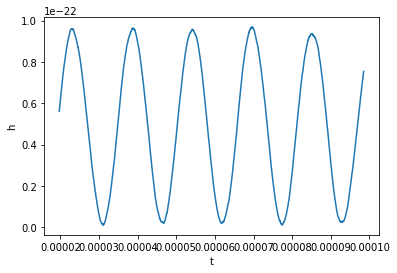

In [16]:
d_Mpc = 500

# inverse = True means from geometrized to physical
gw_physical = gw_complex.time_unit_changed(CU.time, inverse=True)  

gw_physical *= CU.length  # dh -> dh physical
# Now just the strain, since we assume a distance
gw_physical /= (d_Mpc * uc.MEGAPARSEC_SI)

# We have to manually add the redshift
gw_physical.redshifted(luminosity_distance_to_redshift(d_Mpc))

plot(gw_physical.real(), lab1="h")

Okay, now before taking the Fourier transform, we will remove the mean and window our signal. A Tukey window will work.

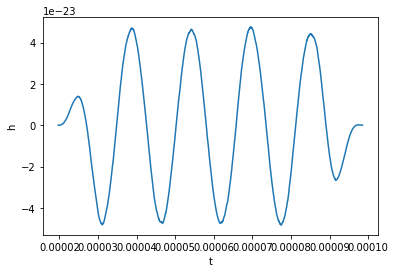

In [17]:
gw_physical.mean_remove()
gw_physical.tukey_window(0.3)
plot(gw_physical.real(), lab1="h")

Finally, we can take the Fourier transform. This is easy to do:

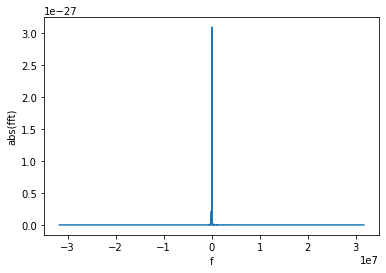

In [18]:
gw_fft = gw_physical.to_FrequencySeries()

# Plotting the amplitude of the Fourier transform
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")

The new object is a `FrequencySeries`. It is very similar to a `TimeSeries` and it shares several properties, methods, and features. 

Let's restrict to only positive frequencies close to zero.

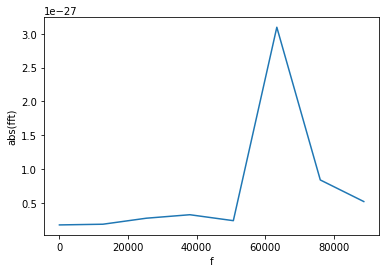

In [19]:
gw_fft.crop(0, 1e5)
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")

We can find the frequency of that peak! For this, we find all the peaks with amplitude larger than 1e-27.

Frequency: 64178.05


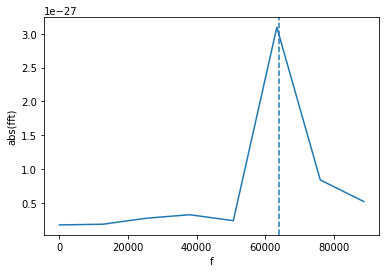

In [20]:
f_peak = gw_fft.peaks_frequencies(1e-27)[0]

print(f"Frequency: {f_peak:.2f}")
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")
plt.axvline(f_peak, ls = 'dashed')

The line is not on the maximum because we use a quadratic interpolation to find a more accurate location of the peak.

Sometimes, it is useful to ignore some data (or example, when we know that the data is invalid). `Series` objects support _masks_ to mark the points we want to ignore. Most functions work transparently with masks: for example, if you ask for the mean of a `Series`, the masked point will be ignored. Other functions do not support masks (most notably, splines). In that case, it is best to completely remove the masked points and work with clean data.

In [21]:
# Let's mask all the point in the spectrum with value larger than 1e-27

spectrum = gw_fft.abs()

print(f"Maximum without mask {spectrum.max():.3e}")

# Apply mask
spectrum.mask_greater(1e-27)

print(f"Maximum with mask {spectrum.max():.3e}")

print(f"Length with mask {len(spectrum)}")

# Remove points
spectrum.mask_remove()

print(f"Length after having removed the masked points {len(spectrum)}")

Maximum without mask 3.095e-27
Maximum with mask 8.403e-28
Length with mask 8
Length after having removed the masked points 7
